In [1]:
import json
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

from transformers import BartTokenizer

In [2]:
PATH = json.load(open('path_config.json'))

In [3]:
xsum_bart = BARTModel.from_pretrained(PATH['bart.large.xsum'],
                                      checkpoint_file='model.pt',
                                      data_name_or_path=PATH['bart.large.xsum'])

In [4]:
bart = BARTModel.from_pretrained(PATH['bart.large'],
                                 checkpoint_file='model.pt',
                                 data_name_or_path=PATH['bart.large'])

#### Read XSum

In [5]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [6]:
from fairseq.data.data_utils import collate_tokens

In [7]:
class ConditionalSequenceGenerator:
    """Conditional sequence generator for calculating prior and posterior probability."""
    def __init__(self, bart):
        self.bart = bart
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
        
        self.encode_func = bart.encode
        self.decode_func = bart.decode
        self.max_positions = bart.max_positions
        self.encode_line = bart.task.source_dictionary.encode_line
        
        self._initialize()
    
    def _initialize(self):
        """Set BART model to evaluation mode."""
        self.bart.cuda()
        self.bart.eval()
        self.bart.half()
        
    def tokenize(self, input_str, append_bos=False, append_eos=True, left_pad=True):
        """BPE-encode a sentence (or multiple sentences).

        Args:
            input_str (str or List[str]): input sentence to be tokenized.
            append_bos (bool): self-explained.
            append_eos (bool): self-explained.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        if type(input_str) == type(''):
            input_str = [input_str]

        input_ids = []
        for ins in input_str:
            tokens = self.bart.bpe.encode(ins)  # <mask>: 1279 27932 29
            calibration = sum([append_bos, append_eos])
            if len(tokens.split(" ")) > min(self.max_positions) - calibration:
                tokens = " ".join(tokens.split(" ")[: min(self.max_positions) - calibration])

            tokens = "<s> " + tokens if append_bos else tokens
            tokens = tokens + " </s>" if append_eos else tokens
            ids = self.encode_line(tokens, append_eos=False).long()
            input_ids.append(ids)

        input_ids = collate_tokens(input_ids, pad_idx=1, left_pad=left_pad).cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()

        return input_ids, input_lengths
    
    def tokenize_with_mask(self, input_str):
        """Tokenize sentence with a special <mask> token in it.

        Args:
            input_str (str or List[str]): input sentence to be tokenized.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        input_ids = self.tokenizer(input_str, return_tensors='pt', padding=True)['input_ids'].cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()
        return input_ids, input_lengths
    
    def generate(self, src_input, tgt_input=None):
        """Conditional generation.
        
        Args:
            src_input (str or List[str]): input source sentence to be tokenized.
            tgt_input (str or List[str]): input target sentence to be tokenized.
        """
        input_ids, lengths = self.tokenize(src_input, append_bos=False) 
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, append_bos=False, left_pad=False)
        
        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2])
        return decoder_output
    
    def mask_filling(self, src_input, tgt_input=None):
        """
        Filling the mask in sentence(s).
        """
        input_ids, lengths = self.tokenize_with_mask(src_input)
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, left_pad=False)

        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2, 0])
        return decoder_output
    
    def encode_sequence(self, input_ids, lengths):
        return self.bart.model.encoder(input_ids, src_lengths=lengths)
        
    def decode_sequence(
        self,
        encoder_out,
        target_ids=None,
        min_decode_step=3,
        max_decode_step=100,
        pad_id=1,
        eos_id=2,
        prefix_tokens=[2, 0],
    ):
        batch_size = encoder_out['encoder_padding_mask'][0].shape[0]
        init_input = torch.tensor([prefix_tokens] * batch_size, dtype=torch.long).cuda()
        token_probs, tokens = None, [[] for i in range(batch_size)]
        end_mask = torch.tensor([False] * batch_size).cuda()

        softmax = nn.Softmax(dim=1)
        for step in range(max_decode_step):
            decoder_outputs = self.bart.model.decoder(init_input, encoder_out, features_only=False)
            logits = decoder_outputs[0][:, -1, :]  # logits: [batch_size, vocab]
            attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]

            if step + 1 < min_decode_step:
                logits[:, eos_id] = -math.inf  # mask <EOS> token when within minimal step
            logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select <PAD> & <BOS> token
            probs = softmax(logits)  # probs: [batch_size, vocab]

            # select tokens
            if target_ids is not None:
                selected_token = target_ids[:, step]
            else:
                value, indices = torch.topk(probs, 5, dim=1)
                selected_token = indices[:, 0]

            selected_token = selected_token.masked_fill(end_mask, pad_id)
            init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
            
            probs = torch.gather(probs, 1, selected_token.unsqueeze(1)).detach()
            probs = probs.masked_fill(end_mask.unsqueeze(1), 1.0)
            
            # str & probability
            token_probs = probs if token_probs is None else torch.cat([token_probs, probs], dim=-1)
            for t, s in zip(tokens, selected_token):
                t.append(self.decode_func(s.unsqueeze(0)) if s.item() != pad_id else '<pad>')
            
            # stop generation when all finished
            end_mask = torch.logical_or(end_mask, selected_token == eos_id) 
            if end_mask.sum().item() == batch_size:
                break

        return init_input, tokens, token_probs

In [8]:
def get_probability(position, tokens, probs, entity):
    """Calculate the probability of a span.

    Args:
        position: (start, end)
        tokens: ['The', ' Archbishop', ' of', ...]
        probs: [0.50, 0.49, 0.88, ...]
        entity: Rodgers
    """
    assert len(tokens) == len(probs), "Tokens and token probabilities does not match."
    
    end_pointer, end_pos = 0, []
    for t in tokens:
        end_pointer += len(t)
        end_pos.append(end_pointer)
    
    assert position[1] in end_pos, "- {}\n- {}\n- {}\n- {}\n- {}\n".format(position, tokens, probs, entity, end_pos)
    last_index = end_pos.index(position[1])
    indexes = [last_index]
    total_length = len(tokens[last_index])
    
    while total_length < (position[1] - position[0]):
        last_index -= 1
        assert last_index >= 0
        indexes.append(last_index)
        total_length += len(tokens[last_index])
    
    indexes.reverse()
    
    generated = ''.join([tokens[i] for i in indexes])
    assert entity in generated, 'entity: {}; span: {}'.format(entity, generated)
    
    prob = 1.0
    for i in indexes:
        prob *= probs[i]
    return prob

In [9]:
def get_cmlm_probability(generator, src_input, tgt_input, position, entity):
    outputs = generator.generate(src_input, tgt_input=tgt_input)
    init_input, tokens, token_probs = outputs
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    
    return probs

In [10]:
def get_prior_probability(generator, src_input, tgt_input, position, entity):
    assert len(src_input) == len(tgt_input), "source & target length should match."
    decoder_output = generator.mask_filling(src_input, tgt_input)
    init_input, tokens, token_probs = decoder_output
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    return probs

#### Test One Example

In [11]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [12]:
INDEX = 9444

source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."

In [13]:
ent_parts = nlp(target).to_json()['ents']
for e in ent_parts:
    print('{} - {}'.format(e, target[e['start']: e['end']]))

{'start': 75, 'end': 82, 'label': 'DATE'} - Cardiff


In [14]:
prior_model = ConditionalSequenceGenerator(bart)

In [15]:
outputs = prior_model.generate([source], tgt_input=[target])
print(outputs)

(tensor([[    2, 23638,   179,    12,   560,    12, 17137,   179, 30387, 15727,
         14115,    36, 14543,  2685,    43,    16,   145, 12962,    30,    10,
          1098,    11, 12426,    11,    10,  2311,     7,  1871,     5,  1074,
             9,  7272,  2421,    19,     5,  1881,     4,     2]],
       device='cuda:0'), [['Tw', 'in', '-', 'to', '-', 'tw', 'in', ' transf', 'usion', ' syndrome', ' (', 'TT', 'TS', ')', ' is', ' being', ' tracked', ' by', ' a', ' hospital', ' in', ' Cardiff', ' in', ' a', ' bid', ' to', ' save', ' the', ' lives', ' of', ' babies', ' born', ' with', ' the', ' condition', '.', '']], tensor([[2.9278e-03, 1.9703e-03, 2.0752e-03, 6.7520e-04, 6.9238e-01, 5.3162e-02,
         6.2695e-01, 5.0391e-01, 0.0000e+00, 1.0729e-06, 5.0306e-04, 1.6093e-06,
         5.9605e-08, 1.5652e-04, 1.7881e-07, 0.0000e+00, 0.0000e+00, 1.7881e-07,
         1.7285e-06, 0.0000e+00, 5.9605e-08, 0.0000e+00, 5.9605e-08, 3.5763e-07,
         0.0000e+00, 1.4126e-05, 0.0000e+00, 2.384

In [16]:
print(get_probability((35, 39), outputs[1][0], outputs[2][0], 'TTTS'))
print(get_probability((75, 82), outputs[1][0], outputs[2][0], 'Cardiff'))

tensor(0., device='cuda:0', dtype=torch.float16)
tensor(0., device='cuda:0', dtype=torch.float16)


In [17]:
generator = ConditionalSequenceGenerator(xsum_bart)

In [18]:
outputs = generator.generate([source], tgt_input=[target])
print(outputs)

(tensor([[    2, 23638,   179,    12,   560,    12, 17137,   179, 30387, 15727,
         14115,    36, 14543,  2685,    43,    16,   145, 12962,    30,    10,
          1098,    11, 12426,    11,    10,  2311,     7,  1871,     5,  1074,
             9,  7272,  2421,    19,     5,  1881,     4,     2]],
       device='cuda:0'), [['Tw', 'in', '-', 'to', '-', 'tw', 'in', ' transf', 'usion', ' syndrome', ' (', 'TT', 'TS', ')', ' is', ' being', ' tracked', ' by', ' a', ' hospital', ' in', ' Cardiff', ' in', ' a', ' bid', ' to', ' save', ' the', ' lives', ' of', ' babies', ' born', ' with', ' the', ' condition', '.', '']], tensor([[0.0227, 0.8320, 0.3792, 0.9434, 0.9243, 0.7979, 0.9238, 0.9062, 0.6479,
         0.8750, 0.0133, 0.3152, 0.8843, 0.9048, 0.3230, 0.3005, 0.0776, 0.2164,
         0.5469, 0.1196, 0.8271, 0.2532, 0.0860, 0.5059, 0.8955, 0.8784, 0.0728,
         0.2229, 0.8784, 0.8901, 0.3474, 0.0228, 0.8271, 0.7759, 0.8584, 0.8950,
         0.9028]], device='cuda:0', dtype=torch.fl

In [19]:
print(get_probability((35, 39), outputs[1][0], outputs[2][0], 'TTTS'))
print(get_probability((75, 82), outputs[1][0], outputs[2][0], 'Cardiff'))

tensor(0.2788, device='cuda:0', dtype=torch.float16)
tensor(0.2532, device='cuda:0', dtype=torch.float16)


#### Read Annotated Data

In [20]:
import json

from tqdm import tqdm

In [21]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

118


In [22]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11'},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100'},
  {'start': 78, 'end': 85, 'label': 0, 'type': 'GPE', 'ent': 'Vanuatu'},
  {'start': 91, 'end': 98, 'label': 1, 'type': 'LOC', 'ent': 'Pacific'}],
 'hallucinations': ['killed at least 11 people and injured more than 100',
  "the Pacific nation's president has said."]}

In [23]:
def prepare_inputs(source, target, ent_parts=None):
    if ent_parts is None:
        ent_parts = nlp(target).to_json()['ents']
    
    entities, positions = [], []
    inputs, targets = [], []

    for e in ent_parts:
        positions.append((e['start'], e['end']))
        entities.append(target[e['start']: e['end']])
        inputs.append(source)
        targets.append(target)

    return inputs, targets, entities, positions

In [24]:
def prepare_masked_inputs(source, target, ent_parts=None):
    if ent_parts is None:
        ent_parts = nlp(target).to_json()['ents']
    
    prior_inputs, prior_targets = [], []
    posterior_inputs, posterior_targets = [], []
    prior_position, posterior_position, entity = [], [], []

    for e in ent_parts:
        entity.append(target[e['start']: e['end']])

        # prior model
        prior_position.append((e['start'], e['end']))
        prior_inputs.append(target[0: e['start']] + '<mask>' + target[e['end']:])
        prior_targets.append(target)

        # posterior model
        posterior_position.append((e['start'] + 4, e['end'] + 4))

        masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
        masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
        posterior_inputs.append(masked_hypothesis)
        posterior_targets.append('<s> ' + target)
    
    prior_args = (prior_inputs, prior_targets, prior_position, entity)
    posterior_args = (posterior_inputs, posterior_targets, posterior_position, entity)
    return prior_args, posterior_args

In [25]:
prior_model = ConditionalSequenceGenerator(bart)
posterior_model = ConditionalSequenceGenerator(xsum_bart)

for INDEX in tqdm(range(len(data))):
    source = xsum_source[data[INDEX]['id']]
    target = data[INDEX]['pred']
    
    inputs, targets, entities, positions = prepare_inputs(source, target, data[INDEX]['ents'])
    pro, pos = prepare_masked_inputs(source, target, data[INDEX]['ents'])
    
    # prior_probs = get_cmlm_probability(prior_model, inputs, targets, positions, entities)
    prior_probs = get_prior_probability(prior_model, pro[0], pro[1], pro[2], pro[3])
    posterior_probs = get_cmlm_probability(posterior_model, inputs, targets, positions, entities)
    
    assert len(prior_probs) == len(posterior_probs) == len(data[INDEX]['ents']), "{};\n {};\n {}".format(prior_probs, posterior_probs, data[INDEX]['ents'])
    for i in range(len(prior_probs)):
        data[INDEX]['ents'][i]['prior'] = prior_probs[i]
        data[INDEX]['ents'][i]['posterior'] = posterior_probs[i]

100%|██████████| 118/118 [02:02<00:00,  1.04s/it]


In [26]:
# import json

In [27]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [28]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

In [30]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

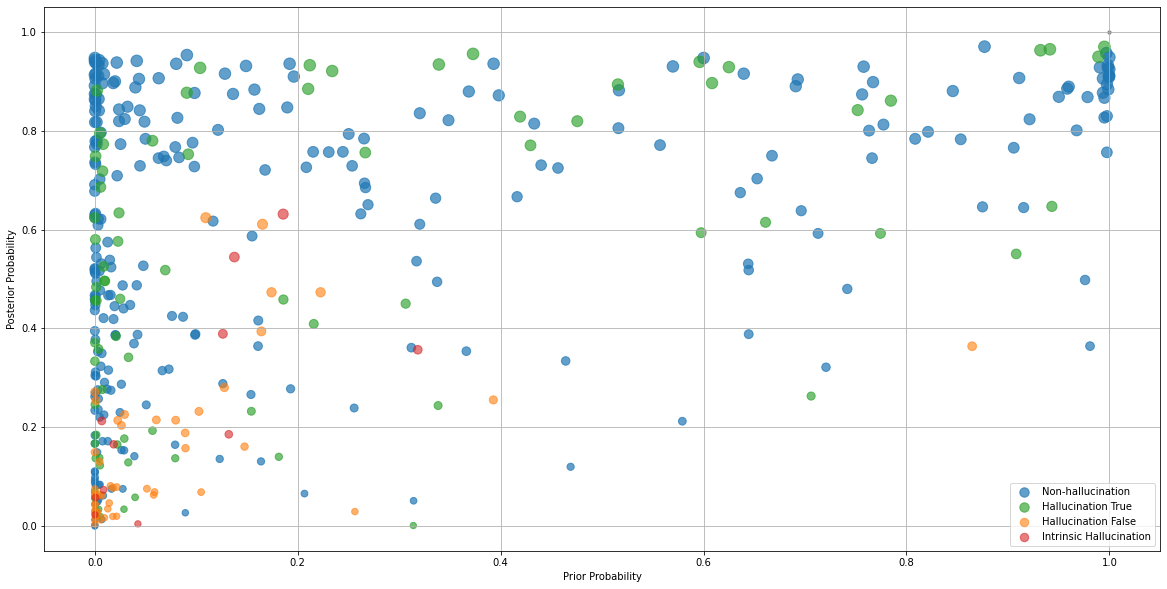

In [31]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [32]:
for p in prior_posterior:
    if p['prior'] > 0.9:
        print(p)

{'start': 27, 'end': 34, 'label': 0, 'type': 'PERSON', 'ent': 'Rodgers', 'prior': 0.99951171875, 'posterior': 0.90771484375, 'id': 7079}
{'start': 70, 'end': 75, 'label': 0, 'type': 'ORDINAL', 'ent': 'first', 'prior': 0.99072265625, 'posterior': 0.92822265625, 'id': 7079}
{'start': 104, 'end': 109, 'label': 0, 'type': 'ORDINAL', 'ent': 'first', 'prior': 0.91552734375, 'posterior': 0.64453125, 'id': 7079}
{'start': 74, 'end': 79, 'label': 1, 'type': 'PERSON', 'ent': 'David', 'prior': 0.9892578125, 'posterior': 0.94970703125, 'id': 1513}
{'start': 83, 'end': 86, 'label': 0, 'type': 'PERSON', 'ent': 'Gea', 'prior': 0.99755859375, 'posterior': 0.82958984375, 'id': 1513}
{'start': 26, 'end': 35, 'label': 0, 'type': 'PERSON', 'ent': 'Tillerson', 'prior': 0.9990234375, 'posterior': 0.8837890625, 'id': 4809}
{'start': 45, 'end': 51, 'label': 1, 'type': 'PERSON', 'ent': 'Barack', 'prior': 0.943359375, 'posterior': 0.64697265625, 'id': 8447}
{'start': 52, 'end': 57, 'label': 0, 'type': 'PERSON',

#### Classification

In [33]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 1.1265277862548828e-05,
 'posterior': 0.0927734375,
 'id': 8805}

In [34]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [35]:
baseline_label = []
prob_threshold_label = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            baseline_label.append(1)
        else:
            baseline_label.append(0)

        if p['posterior'] > p['prior']:
            prob_threshold_label.append(1)
        else:
            prob_threshold_label.append(0)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(factual_label, baseline_label, target_names=['Non-factual', 'Factual']))

              precision    recall  f1-score   support

 Non-factual       0.36      0.98      0.52        50
     Factual       1.00      0.74      0.85       347

    accuracy                           0.77       397
   macro avg       0.68      0.86      0.69       397
weighted avg       0.92      0.77      0.81       397



In [38]:
print(classification_report(factual_label, prob_threshold_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.0769    0.1000    0.0870        50
     Factual     0.8645    0.8271    0.8454       347

    accuracy                         0.7355       397
   macro avg     0.4707    0.4635    0.4662       397
weighted avg     0.7653    0.7355    0.7498       397



In [39]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], prob_threshold_label, target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.2462    0.1260    0.1667       127
    Hallucinated     0.6657    0.8185    0.7342       270

        accuracy                         0.5970       397
       macro avg     0.4559    0.4723    0.4504       397
    weighted avg     0.5315    0.5970    0.5527       397



### KNN

In [40]:
import numpy as np

from sklearn import neighbors

In [41]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 1.1265277862548828e-05,
 'posterior': 0.0927734375,
 'id': 8805}

In [42]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [52]:
preds = leave_one_out_error(posterior_probabilities, prior_probabilities, hallucination_label, n_neighbors=6)

In [53]:
print(classification_report(hallucination_label, preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.7284    0.9037    0.8066       270
Non-hallucinated     0.5806    0.2835    0.3810       127

        accuracy                         0.7053       397
       macro avg     0.6545    0.5936    0.5938       397
    weighted avg     0.6811    0.7053    0.6704       397



In [54]:
preds = leave_one_out_error(posterior_probabilities, prior_probabilities, factual_label, n_neighbors=6)

In [55]:
print(classification_report(factual_label, preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.4792    0.4600    0.4694        50
     Factual     0.9226    0.9280    0.9253       347

    accuracy                         0.8690       397
   macro avg     0.7009    0.6940    0.6973       397
weighted avg     0.8668    0.8690    0.8679       397



#### AUC

In [47]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [48]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 1.1265277862548828e-05,
 'posterior': 0.0927734375,
 'id': 8805}

In [49]:
# non-hallucination vs false hallucination

In [50]:
factual_label = np.asarray(factual_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)

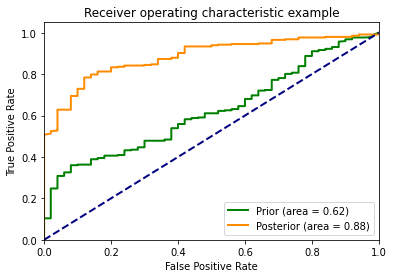

In [51]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(factual_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(factual_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()